In [61]:
import csv
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from requests.exceptions import RequestException
import time
import pandas as pd
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns
from sklearn.manifold import MDS
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from tabulate import tabulate
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

**Task 1: Scraping Edmounds.com**

In [3]:
#Scrape one page

# Create a session object to persist settings across requests
session = requests.Session()

# TODO: Add retry logic to handle server errors (Hint: Use the Retry and HTTPAdapter classes)
retries = Retry(
    total=3,               # Number of total retries
    backoff_factor=1,   
    status_forcelist=[500, 502, 503, 504]  # Retry on these HTTP codes
)
adapter = HTTPAdapter(max_retries=retries)
session.mount('http://', adapter)
session.mount('https://', adapter)

# TODO: Set up headers to mimic a browser (Hint: User-Agent and Accept headers)
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'
}
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
        "(KHTML, like Gecko) Chrome/114.0.5735.110 Safari/537.36"
    ),
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Referer": "https://www.google.com/",
    'Accept-Encoding': 'gzip, deflate, br',  # Acceptable encodings to save bandwidth
    'Connection': 'keep-alive',  # Keep connection open for reuse
}

url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans'

# Make the request to the URL (Hint: use session.get)
response = requests.get(url, headers=headers)
html_content = response.text

# Make sure to raise an exception for any bad response
response.raise_for_status()

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Extract comments
comments = soup.find_all('div', class_='Comment')

# Prepare to store extracted data
extracted_data = []

# Loop through each comment to extract the required fields
for comment in comments:
    # Extract the date
    date_tag = comment.find('span', class_='MItem DateCreated').find('time')
    date = date_tag.get('title') if date_tag else None
    
    # Extract the user-id
    user_link = comment.find('a', class_='Username js-userCard')
    user_id = user_link.get('data-userid') if user_link else None
    
    # Extract the message
    message_div = comment.find('div', class_='Message userContent')
    message = message_div.get_text(strip=True) if message_div else None
    
    # Append to the results if all fields are found
    if date and user_id and message:
        extracted_data.append({
            'date': date,
            'user-id': user_id,
            'message': message
        })

# Print the extracted data
for entry in extracted_data:
    print(f"Date: {entry['date']}")
    print(f"User ID: {entry['user-id']}")
    print(f"Message: {entry['message']}")
    print("-" * 40)

Date: March 24, 2002 9:54PM
User ID: 409683
Message: I personally think that with a few tweaks the C320 could also sit at the top of this group.  It's still more of a entry-level luxury sedan than Mercedes would lead you to believe.   The C320 "Sport" needs to have it's suspension retuned to accept 17 inch tires without a harsh ride.  MB also needs to stop forcing metal trim and black leather on everyone that wants the sport package.  The C240's 6-speed wouldn't hurt either if offered on the C320, though it needs to be "fixed" first.That said, my favorite of the group is (gasp!) the new A4 3.0.   The A4 easily has the best interior of any sub-40K car, combine that with stunning looks and a body that is as rigid as any ever made and you have my personal favorite.   The single thing I don't like about the A4 is the grey trim around the bottom of the car.  This trim doesn't match any of the body colors, as it should be body color anyway.   This is an excellent car and in my opinion the be

In [11]:
comments_df = pd.DataFrame(extracted_data)
comments_df.rename(columns = {'user-id': 'User_ID', 'message': 'Message', 'date': 'Date'}, inplace = True)

#Add a column Pagination and add 1 as all values
comments_df['Pagination'] = 1
comments_df.head()
#comments_df.shape

,Date,User_ID,Message,Pagination
0,"March 24, 2002 9:54PM",409683,I personally think that with a few tweaks the ...,1
1,"March 24, 2002 11:06PM",224560,I am debating a new purchase and these two are...,1
2,"March 25, 2002 9:02AM",75564,"Great handling, RWD, excellent engine and the ...",1
3,"March 25, 2002 3:04PM",274013,And no manual tranny. That may not matter to ...,1
4,"March 25, 2002 4:44PM",411559,One beauty of BMW 3 Series is that there are s...,1


In [20]:
#Have a loop that go through pagination from p20 to page 120 to get 5000 comments
import random

for p in range(31,120):    
    url = f'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{p}'
    print(p)
    try:
            # Make the request to the URL
            response = requests.get(url, headers=headers)
            response.raise_for_status()
            html_content = response.text

            # Parse the HTML content using BeautifulSoup
            soup = BeautifulSoup(html_content, 'html.parser')

            # Extract comments
            comments = soup.find_all('div', class_='Comment')

            # Loop through each comment to extract the required fields
            for comment in comments:
                # Extract the date
                date_tag = comment.find('span', class_='MItem DateCreated').find('time')
                date = date_tag.get('title') if date_tag else None
                
                # Extract the user-id
                user_link = comment.find('a', class_='Username js-userCard')
                user_id = user_link.get('data-userid') if user_link else None
                
                # Extract the message
                message_div = comment.find('div', class_='Message userContent')
                message = message_div.get_text(strip=True) if message_div else None
                
                # Append to DataFrame if all fields are found
                if date and user_id and message:
                    comments_df = pd.concat([comments_df, pd.DataFrame([{
                        'Date': date,
                        'User_ID': user_id,
                        'Message': message,
                        'Pagination': p
                    }])], ignore_index=True)

    except Exception as e:
        print(f"Failed to process page {p}: {e}")
    
    # Add a random delay between 2 and 10 seconds
    time.sleep(random.randint(5, 10))

31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


In [86]:
#Save the scraped columns as a file
comments_df.shape
comments_df.rename(columns = {'User_ID':'user-id', 'Message':'message', 'Date':'date', 'Pagination':'pagination' }, inplace = True)
comments_df.to_csv(r"E:\MMA\Winter 2025\insy669 text\Assignments\comments_extracted.csv")

In [29]:
#read the file that contains the list of the brands and models
car_brands_models = pd.read_csv(r"E:\MMA\Winter 2025\insy669 text\Assignments\Car Models Assignment 1 Data.csv")
car_brands_models.columns = ['Brand', 'Model']
car_brands_models['Brand'].value_counts()
car_brands_models.shape

#Remove seat, car, problem and sedan from Brands
car_brands_models = car_brands_models[~car_brands_models['Brand'].isin(['seat','car','sedan','problem'])]
car_brands_models.shape

#Handle cases in brand column that are the same but have punctuation: 'kia', 'kia,', 'kia.'
car_brands_models['Brand'] = car_brands_models['Brand'].str.replace(r'[^\w\s]', '', regex=True)

car_brands_models['Brand'].value_counts()


Brand
toyota        98
chevrolet     63
honda         46
hyundai       40
mazda         30
suzuki        29
ford          24
bmw           22
subaru        21
nissan        19
pontiac       17
volkswagen    14
dodge         12
infiniti      10
audi          10
kia           10
chrysler       9
lincoln        8
acura          8
buick          8
volvo          7
mercedes       7
cadillac       3
mercury        2
mitsubishi     2
hyndai kia     1
saturn         1
toyata         1
volkwagen      1
Name: count, dtype: int64

In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')

# Load the dataset
comments_df = pd.read_csv(r"E:\MMA\Winter 2025\insy669 text\Assignments\comments_extracted.csv")

# Load the stopwords
stop_words = set(stopwords.words('english'))

#Make a dictionary from models and brands
model_to_brand = dict(zip(car_brands_models['Model'], car_brands_models['Brand']))

# Function to process each comment
def process_comment(comment):
    # Clean the text: Convert to lowercase, remove punctuation (except "-"), and split into words
    processed = comment.lower()
    processed = re.sub(r'[^\w\s-]', '', processed)  # Remove punctuation except "-"
    words = processed.split()
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Replace models with their corresponding brands
    words = [model_to_brand[word] if word in model_to_brand else word for word in words]
    
    return words

# Apply processing to each comment
comments_df['tokenized_words'] = comments_df['message'].apply(process_comment)

comments_df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Behzad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,date,user-id,message,pagination,tokenized_words
0,0,"March 24, 2002 9:54PM",409683,I personally think that with a few tweaks the ...,1,"[personally, think, tweaks, c320, could, also,..."
1,1,"March 24, 2002 11:06PM",224560,I am debating a new purchase and these two are...,1,"[debating, new, purchase, two, top, list, pric..."
2,2,"March 25, 2002 9:02AM",75564,"Great handling, RWD, excellent engine and the ...",1,"[great, handling, rwd, excellent, engine, best..."
3,3,"March 25, 2002 3:04PM",274013,And no manual tranny. That may not matter to ...,1,"[manual, tranny, may, matter, certainly, matte..."
4,4,"March 25, 2002 4:44PM",411559,One beauty of BMW 3 Series is that there are s...,1,"[one, beauty, bmw, 3, series, many, models, ch..."
...,...,...,...,...,...,...
5034,5034,"October 2, 2006 5:29AM",149579,I agree totally. Jags are pretty rare around h...,119,"[agree, totally, jags, pretty, rare, around, s..."
5035,5035,"October 2, 2006 5:43AM",409608,"this thread isn't just about ""entry level luxu...",119,"[thread, isnt, entry, level, luxury, entry, le..."
5036,5036,"October 2, 2006 5:49AM",410758,My line-up:2008' Cadillac CTS2008-2009' Holden...,119,"[line-up2008, cadillac, cts2008-2009, holden, ..."
5037,5037,"October 2, 2006 5:59AM",388576,"Well it was going to be until BMW, didn't do a...",119,"[well, going, bmw, didnt, anything, improve, c..."


In [31]:
#To check if the substition worked: yes, s60 -> volvo
comments_df[1000:1100]

#models_0 = [word for word in updated_words if word in car_brands_models['Model']]
#models_0

,Unnamed: 0,date,user-id,message,pagination,tokenized_words
1000,1000,"April 9, 2004 8:40PM",318864,I wish I could take extended road trips in eve...,39,"[wish, could, take, extended, road, trips, eve..."
1001,1001,"April 9, 2004 9:10PM",150674,"Those driving manner are dangerous, no matter ...",39,"[driving, manner, dangerous, matter, car, tl, ..."
1002,1002,"April 10, 2004 1:02AM",75564,challenging the unexpected? is it possible wit...,39,"[challenging, unexpected, possible, without, e..."
1003,1003,"April 10, 2004 5:20AM",6344,And here's mine :1)Audi A42)Volvo S60 R3)BMW33...,39,"[heres, mine, 1audi, a42volvo, volvo, r3bmw330..."
1004,1004,"April 10, 2004 8:32AM",409942,"Hmmm, my definition if ""Tramlining"" is when yo...",39,"[hmmm, definition, tramlining, driving, roads,..."
...,...,...,...,...,...,...
1095,1095,"April 20, 2004 11:23PM",332885,Check out jdpowers.com for initial quality rat...,41,"[check, jdpowerscom, initial, quality, ratings..."
1096,1096,"April 20, 2004 11:42PM",6344,out of 37 nameplates :lexus 1stinfinity 2ndacu...,41,"[37, nameplates, lexus, 1stinfinity, 2ndacura,..."
1097,1097,"April 20, 2004 11:53PM",332885,Re: vdi 2003 rankingsThat study surveys cars t...,41,"[vdi, 2003, rankingsthat, study, surveys, cars..."
1098,1098,"April 21, 2004 4:25AM",121952,A 10 year warranty has all but eliminated past...,41,"[10, year, warranty, eliminated, past, concern..."


In [32]:
# Create a set of all brands for faster lookup
brands_set = set(car_brands_models['Brand'])

# Extract brands mentioned in each comment's tokenized words
comments_df['brands_mentioned'] = comments_df['tokenized_words'].apply(
    lambda tokens: [brand for brand in tokens if brand in brands_set]
)

comments_df.drop(columns = ['Unnamed: 0'],inplace = True)
comments_df

,date,user-id,message,pagination,tokenized_words,brands_mentioned
0,"March 24, 2002 9:54PM",409683,I personally think that with a few tweaks the ...,1,"[personally, think, tweaks, c320, could, also,...","[mercedes, audi, audi, audi, audi, bmw, bmw, a..."
1,"March 24, 2002 11:06PM",224560,I am debating a new purchase and these two are...,1,"[debating, new, purchase, two, top, list, pric...","[acura, honda]"
2,"March 25, 2002 9:02AM",75564,"Great handling, RWD, excellent engine and the ...",1,"[great, handling, rwd, excellent, engine, best...",[]
3,"March 25, 2002 3:04PM",274013,And no manual tranny. That may not matter to ...,1,"[manual, tranny, may, matter, certainly, matte...",[]
4,"March 25, 2002 4:44PM",411559,One beauty of BMW 3 Series is that there are s...,1,"[one, beauty, bmw, 3, series, many, models, ch...",[bmw]
...,...,...,...,...,...,...
5034,"October 2, 2006 5:29AM",149579,I agree totally. Jags are pretty rare around h...,119,"[agree, totally, jags, pretty, rare, around, s...","[bmw, mercedes, mercedes, bmw, mercedes]"
5035,"October 2, 2006 5:43AM",409608,"this thread isn't just about ""entry level luxu...",119,"[thread, isnt, entry, level, luxury, entry, le...",[]
5036,"October 2, 2006 5:49AM",410758,My line-up:2008' Cadillac CTS2008-2009' Holden...,119,"[line-up2008, cadillac, cts2008-2009, holden, ...","[cadillac, acura, lincoln, infiniti, dodge]"
5037,"October 2, 2006 5:59AM",388576,"Well it was going to be until BMW, didn't do a...",119,"[well, going, bmw, didnt, anything, improve, c...","[bmw, bmw, bmw, acura, bmw, chrysler, chrysler..."


**Task 2: Identify the top 10 brands by frequency.**


In [88]:
# Flatten the list of brands while removing duplicates for each row
brand_counts = Counter(brand for brands in comments_df['brands_mentioned'] for brand in set(brands))

# Get the top 50 most common words
top_10_brands = brand_counts.most_common(10)

# Convert to DataFrame and call it top_10_df
top_10_brand_df = pd.DataFrame(top_10_brands)

print("Top 10 brands Frequency table")
top_10_brand_df

Top 10 brands Frequency table


,0,1
0,bmw,1407
1,audi,393
2,infiniti,368
3,acura,333
4,honda,257
5,nissan,246
6,toyota,205
7,mercedes,193
8,subaru,146
9,volkswagen,136


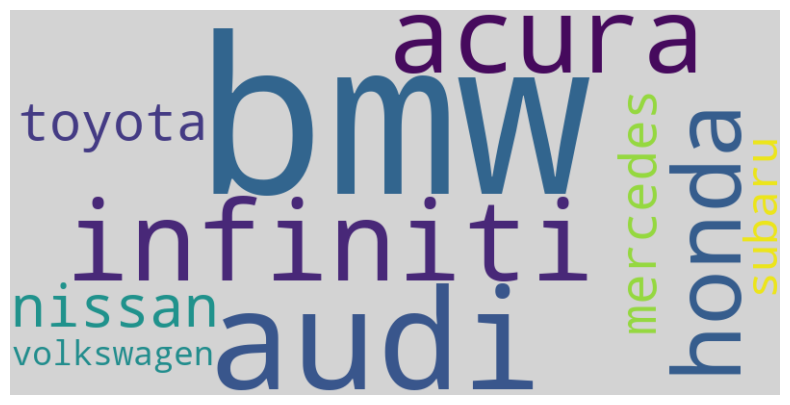

In [36]:
# Convert the first column (brands) and second column (frequencies) into a dictionary
word_freq_dict = dict(zip(top_10_brand_df[0], top_10_brand_df[1]))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='lightgrey').generate_from_frequencies(word_freq_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for the word cloud
plt.show()


Lift Matrix for Top 10 Brands:

            acura   audi    bmw  honda  infiniti  mercedes  nissan  subaru  \
acura         NaN  2.503  1.645  2.650     4.112     2.823   1.907   2.280   
audi        2.503    NaN  1.604  1.596     2.300     3.521   1.512   2.108   
bmw         1.645  1.604    NaN  1.073     1.859     1.763   1.121   1.251   
honda       2.650  1.596  1.073    NaN     1.279     2.133   5.659   1.612   
infiniti    4.112  2.300  1.859  1.279       NaN     1.916   2.672   1.876   
mercedes    2.823  3.521  1.763  2.133     1.916       NaN   1.592   1.252   
nissan      1.907  1.512  1.121  5.659     2.672     1.592     NaN   1.684   
subaru      2.280  2.108  1.251  1.612     1.876     1.252   1.684     NaN   
toyota      1.845  1.001  1.363  5.930     1.069     2.929   5.296   1.852   
volkswagen  1.446  3.771  1.448  2.595     1.712     3.072   3.765   1.776   

            toyota  volkswagen  
acura        1.845       1.446  
audi         1.001       3.771  
bmw       

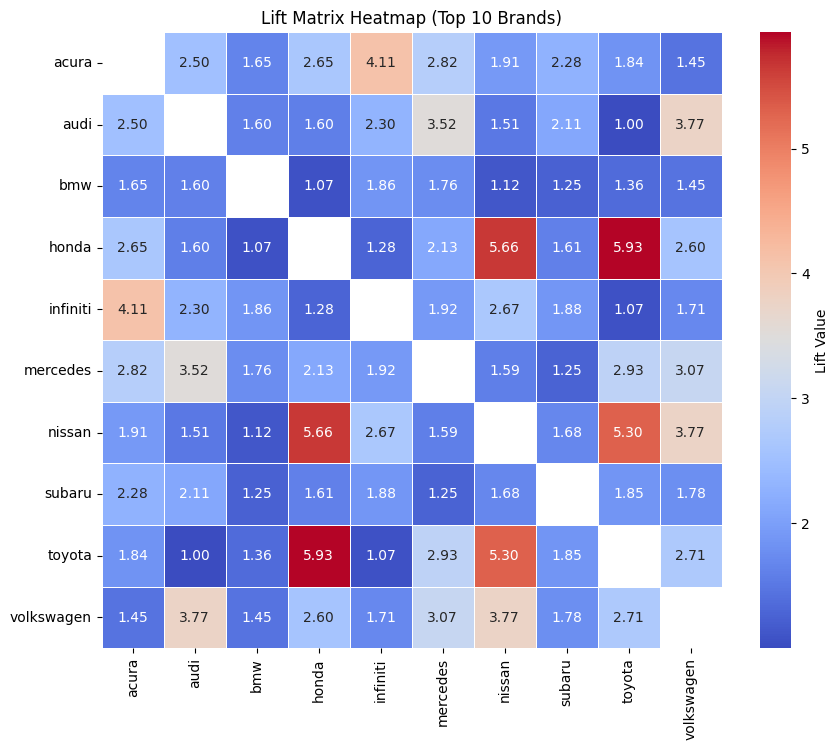

In [42]:
# Convert 'brands_mentioned' to a space-separated string format for vectorization
comments_df['brands_string'] = comments_df['brands_mentioned'].apply(lambda x: ' '.join(x))

# Use CountVectorizer to create the term-document matrix for all brands
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(comments_df['brands_string'])

# Get the brand names (columns in the matrix)
all_brands = vectorizer.get_feature_names_out()

# Filter the brands to include only those in top_10_brand_df[0]
top_10_brands = top_10_brand_df[0].tolist()  # Convert to a list
top_10_indices = [i for i, brand in enumerate(all_brands) if brand in top_10_brands]

# Subset the term-document matrix to only include top 10 brands
X_top_10 = X[:, top_10_indices]
filtered_brands = [all_brands[i] for i in top_10_indices]  # Get the filtered brand names

# Create the co-occurrence matrix
co_occurrence_matrix = (X_top_10.T @ X_top_10).toarray()

# Set diagonal (self-co-occurrence) to zero
np.fill_diagonal(co_occurrence_matrix, 0)

# Compute the word frequencies (number of reviews each brand appears in)
brand_frequencies = X_top_10.sum(axis=0).A1

# Calculate the expected co-occurrence matrix
expected_co_occurrence_matrix = np.outer(brand_frequencies, brand_frequencies) / X_top_10.shape[0]

# Calculate the lift matrix
lift_matrix = co_occurrence_matrix / expected_co_occurrence_matrix

# Convert the lift matrix to a DataFrame for easier visualization
lift_df = pd.DataFrame(lift_matrix, index=filtered_brands, columns=filtered_brands)

# Replace 0 values with NaN to avoid clutter
lift_df.replace(0, np.nan, inplace=True)

# Format the values to 3 decimal places
lift_df = lift_df.round(3)

# Display the lift matrix
print("Lift Matrix for Top 10 Brands:\n")
print(lift_df)

# Visualize the lift matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(lift_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={'label': 'Lift Value'})
plt.title('Lift Matrix Heatmap (Top 10 Brands)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [44]:
# Assuming lift_df is the lift matrix DataFrame
# Replace zero or NaN values in the lift matrix to avoid division by zero
lift_df = lift_df.replace([np.inf, -np.inf, 0], np.nan)

# Calculate the dissimilarity matrix by taking the inverse of the lift values
dissimilarity_matrix = 1/lift_df

# Replace NaN values (due to division by zero) with a large value indicating maximum dissimilarity
dissimilarity_matrix.fillna(dissimilarity_matrix.max().max() * 2, inplace=True)

dissimilarity_matrix

,acura,audi,bmw,honda,infiniti,mercedes,nissan,subaru,toyota,volkswagen
acura,1.998002,0.399521,0.607903,0.377358,0.243191,0.354233,0.524384,0.438596,0.542005,0.691563
audi,0.399521,1.998002,0.623441,0.626566,0.434783,0.284010,0.661376,0.474383,0.999001,0.265182
bmw,0.607903,0.623441,1.998002,0.931966,0.537924,0.567215,0.892061,0.799361,0.733676,0.690608
honda,0.377358,0.626566,0.931966,1.998002,0.781861,0.468823,0.176710,0.620347,0.168634,0.385356
infiniti,0.243191,0.434783,0.537924,0.781861,1.998002,0.521921,0.374251,0.533049,0.935454,0.584112
mercedes,0.354233,0.284010,0.567215,0.468823,0.521921,1.998002,0.628141,0.798722,0.341413,0.325521
nissan,0.524384,0.661376,0.892061,0.176710,0.374251,0.628141,1.998002,0.593824,0.188822,0.265604
subaru,0.438596,0.474383,0.799361,0.620347,0.533049,0.798722,0.593824,1.998002,0.539957,0.563063
toyota,0.542005,0.999001,0.733676,0.168634,0.935454,0.341413,0.188822,0.539957,1.998002,0.368868
volkswagen,0.691563,0.265182,0.690608,0.385356,0.584112,0.325521,0.265604,0.563063,0.368868,1.998002


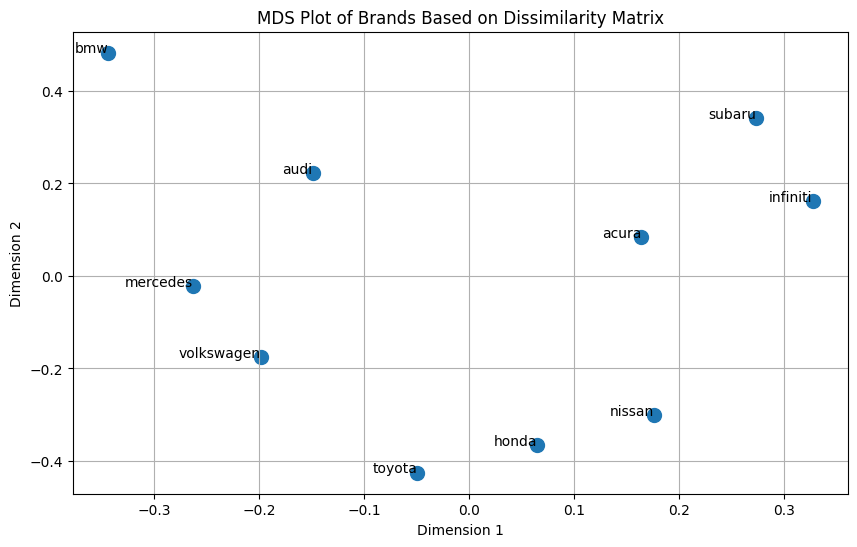

In [45]:
# Convert dissimilarity matrix DataFrame to NumPy array
dissimilarity_array = np.array(dissimilarity_matrix)

# Apply MDS to reduce to 2 dimensions
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coordinates = mds.fit_transform(dissimilarity_array)

# Create a DataFrame for the MDS results
mds_df = pd.DataFrame(mds_coordinates, columns=['Dimension 1', 'Dimension 2'], index=dissimilarity_matrix.index)

# Plot the MDS result
plt.figure(figsize=(10, 6))
plt.scatter(mds_df['Dimension 1'], mds_df['Dimension 2'], s=100)

# Annotate each point with the wordf
for word, (x, y) in mds_df.iterrows():
    plt.text(x, y, word, fontsize=10, ha='right')

plt.title('MDS Plot of Brands Based on Dissimilarity Matrix')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


**Task 3: What insights can you offer brand managers from your analysis in Task 2?**


*Analysis*:

Based on the lift matrix and the MDS plot, one of the strongest associations is between Toyota, Honda, and Nissan. The lift between each pair exceeds 5, which indicates that these brands co-occur more often than expected by chance. Additionally, they form a clear cluster on the MDS plot. Their proximity in the plot suggests low dissimilarity between them, meaning people frequently mention these three brands together. 

Mercedes and Volkswagen also show a high lift with Audi, and this is reflected in the MDS plot, where they appear close to each other. 

Another cluster on the graph is formed by another trio: Subaru, Infiniti, and Acura. The lift for the pair (Infiniti, Acura) is notably high, showing a significant positive association. The two other pairs in this cluster also have a lift above 1, suggesting that their similarity leads to frequent mentions together. 

On the other hand, BMW stands out as a unique brand in th eMDS plot and its lift with other brands is not much higher than 1. It appears as an outlier, which in this context suggests that BMW has distinct characteristics.

*Execative summary*:

Our analysis reveals some key associations among car brands based on how frequently they are mentioned together. Toyota, Honda, and Nissan are strongly connected in consumers' minds, often appearing together and forming a clear group. This suggests they are seen as similar and likely cater to overlapping preferences or needs.

Similarly, Mercedes, Volkswagen, and Audi are frequently mentioned together and form another group. This indicates that they are perceived as part of the same category, likely associated with luxury or premium vehicles.

Another notable cluster includes Subaru, Infiniti, and Acura. These brands are mentioned together often, likely due to shared features or a perception that they are close substitutes.

In contrast, BMW stands apart from other brands, appearing as distinct in the analysis. This suggests that BMW appeals to a unique audience and its users may not consider other brands as substitutes.


**Task 4: What are the 5 most frequently mentioned attributes of cars in the discussions?**

In [56]:
top_5_brands = list(top_10_brand_df[:5][0])
top_5_brands 

['bmw', 'audi', 'infiniti', 'acura', 'honda']

In [55]:
#I am going to filter the dataset of comments and only pick the 5 most frequently mentioned brands

top_5_brands_comments_df = comments_df[comments_df['brands_mentioned'].apply(
    lambda brands: any(brand in top_5_brands for brand in brands))]
top_5_brands_comments_df

,date,user-id,message,pagination,tokenized_words,brands_mentioned,brands_string,lemmatized_words,lemmatization_table
0,"March 24, 2002 9:54PM",409683,I personally think that with a few tweaks the ...,1,"[personally, think, tweaks, c320, could, also,...","[mercedes, audi, audi, audi, audi, bmw, bmw, a...",mercedes audi audi audi audi bmw bmw acura bui...,+---------------+---------------+\n| Origina...,+----------+------------+\n| Original | Lemmat...
1,"March 24, 2002 11:06PM",224560,I am debating a new purchase and these two are...,1,"[debating, new, purchase, two, top, list, pric...","[acura, honda]",acura honda,+---------------+---------------+\n| Origina...,+----------+------------+\n| Original | Lemmat...
4,"March 25, 2002 4:44PM",411559,One beauty of BMW 3 Series is that there are s...,1,"[one, beauty, bmw, 3, series, many, models, ch...",[bmw],bmw,+---------------------+---------------------+\...,+----------+------------+\n| Original | Lemmat...
10,"March 26, 2002 6:55PM",409730,If I had to rank the entry lux performance sed...,1,"[rank, entry, lux, performance, sedans, would,...",[audi],audi,+-----------------+-----------------+\n| Or...,+----------+------------+\n| Original | Lemmat...
11,"March 26, 2002 9:06PM",409942,"Hey my friend, dig this, in Australia, the ONL...",1,"[hey, friend, dig, australia, bmw, manual, gea...","[bmw, bmw]",bmw bmw,+--------------+--------------+\n| Original ...,+----------+------------+\n| Original | Lemmat...
...,...,...,...,...,...,...,...,...,...
5030,"October 2, 2006 4:15AM",388576,"Rocky, we all know you are one big domestic (e...",119,"[rocky, know, one, big, domestic, especially, ...","[bmw, bmw, acura]",bmw bmw acura,+--------------------+--------------------+\n|...,+----------+------------+\n| Original | Lemmat...
5031,"October 2, 2006 4:48AM",410758,"Wow, I'm sure glad you guys pay such close att...",119,"[wow, im, sure, glad, guys, pay, close, attent...","[bmw, bmw, acura, acura, chrysler]",bmw bmw acura acura chrysler,+--------------+--------------+\n| Original ...,+----------+------------+\n| Original | Lemmat...
5034,"October 2, 2006 5:29AM",149579,I agree totally. Jags are pretty rare around h...,119,"[agree, totally, jags, pretty, rare, around, s...","[bmw, mercedes, mercedes, bmw, mercedes]",bmw mercedes mercedes bmw mercedes,+-----------------+-----------------+\n| Or...,+----------+------------+\n| Original | Lemmat...
5036,"October 2, 2006 5:49AM",410758,My line-up:2008' Cadillac CTS2008-2009' Holden...,119,"[line-up2008, cadillac, cts2008-2009, holden, ...","[cadillac, acura, lincoln, infiniti, dodge]",cadillac acura lincoln infiniti dodge,+------------------+------------------+\n| ...,+----------+------------+\n| Original | Lemmat...


In [ ]:
#top_5_brands_comments_df.drop(columns=['lemmatizied_words'],inplace = True)
#top_5_brands_comments_df

In [65]:
#I have cleaned the test in terms of removing stop words, punctiation and lowering the text 
# and now I do lemmatizing to get the root of the words and be able to look for car attributions and map them with the top brands. 
# 
# Download NLTK data files (only needs to be run once)
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Helper function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Lemmatization function
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(tokens)
    lemmatized = []
    for word, tag in pos_tags:
        wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN  # Default to NOUN if POS is not found
        lemmatized.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
    return lemmatized

# Ensure tokenized_words is a list of strings for each row and then apply the lemmetization function
top_5_brands_comments_df['tokenized_words'] = top_5_brands_comments_df['tokenized_words'].apply(
    lambda x: [str(word) for word in x] if isinstance(x, list) else [])

top_5_brands_comments_df['lemmatized_words'] = comments_df['tokenized_words'].apply(lemmatize_tokens)

top_5_brands_comments_df.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Behzad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Behzad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Behzad\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8612\383080429.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_brands_comments_df['tokenized_words'] = top_5_brands_comments_df['tokenized_words'].apply(
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8612\383080429.py:36: Sett

,date,user-id,message,pagination,tokenized_words,brands_mentioned,brands_string,lemmatized_words
0,"March 24, 2002 9:54PM",409683,I personally think that with a few tweaks the ...,1,"[personally, think, tweaks, c320, could, also,...","[mercedes, audi, audi, audi, audi, bmw, bmw, a...",mercedes audi audi audi audi bmw bmw acura bui...,"[personally, think, tweak, c320, could, also, ..."
1,"March 24, 2002 11:06PM",224560,I am debating a new purchase and these two are...,1,"[debating, new, purchase, two, top, list, pric...","[acura, honda]",acura honda,"[debate, new, purchase, two, top, list, price,..."
4,"March 25, 2002 4:44PM",411559,One beauty of BMW 3 Series is that there are s...,1,"[one, beauty, bmw, 3, series, many, models, ch...",[bmw],bmw,"[one, beauty, bmw, 3, series, many, model, cho..."
10,"March 26, 2002 6:55PM",409730,If I had to rank the entry lux performance sed...,1,"[rank, entry, lux, performance, sedans, would,...",[audi],audi,"[rank, entry, lux, performance, sedan, would, ..."
11,"March 26, 2002 9:06PM",409942,"Hey my friend, dig this, in Australia, the ONL...",1,"[hey, friend, dig, australia, bmw, manual, gea...","[bmw, bmw]",bmw bmw,"[hey, friend, dig, australia, bmw, manual, gea..."


In [69]:
top_5_brands_comments_df['lemmatized_words'].to_csv('E:\MMA\Winter 2025\insy669 text\Assignments\lemmatized_comments.csv')

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8612\3081246677.py:1: SyntaxWarning: invalid escape sequence '\M'
  top_5_brands_comments_df['lemmatized_words'].to_csv('E:\MMA\Winter 2025\insy669 text\Assignments\lemmatized_comments.csv')


In [72]:
#This mapping of words to their corresponding car attribute categories (e.g., "performance," "design," etc.) was made by chatGPT,
# based on the dataset of lemmatized words mentione in the comments

car_attributes_df = pd.read_csv('E:\MMA\Winter 2025\insy669 text\Assignments\Word_to_Category_Mapping.csv')
car_attributes_df

<>:4: SyntaxWarning: invalid escape sequence '\M'
<>:4: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8612\341127537.py:4: SyntaxWarning: invalid escape sequence '\M'
  car_attributes_df = pd.read_csv('E:\MMA\Winter 2025\insy669 text\Assignments\Word_to_Category_Mapping.csv')


,Word,Category
0,performance,performance
1,power,performance
2,torque,performance
3,speed,performance
4,acceleration,performance
5,look,design
6,style,design
7,design,design
8,appearance,design
9,aesthetic,design


In [81]:
# Identify the top 5 most frequently mentioned brands
top_5_brands = top_5_brands_comments_df['brands_mentioned'].explode().value_counts().head(5).index.tolist()

# Create a dictionary to map words to their attribute categories
word_to_category = dict(zip(car_attributes_df['Word'], car_attributes_df['Category']))

# Initialize a dictionary to store counts for each brand and attribute category
attribute_counts = {brand: {category: 0 for category in car_attributes_df['Category'].unique()} for brand in top_5_brands}

# Count occurrences of attribute categories with each brand
for _, row in top_5_brands_comments_df.iterrows():
    brands = row['brands_mentioned']
    tokens = row['lemmatized_words']
    
    for brand in brands:
        if brand in top_5_brands: 
            for token in tokens:
                if token in word_to_category: 
                    category = word_to_category[token]
                    attribute_counts[brand][category] += 1

attribute_matrix = pd.DataFrame(attribute_counts).T  # Transpose to have brands as rows and attributes as columns
attribute_matrix

,performance,design,comfort,technology,fuel_efficiency,safety,handling,build_quality
bmw,1970,1558,578,250,486,71,474,653
audi,539,673,214,40,120,38,221,286
infiniti,343,339,307,137,75,13,154,143
acura,373,293,138,112,31,45,106,127
honda,296,260,64,54,36,49,69,84


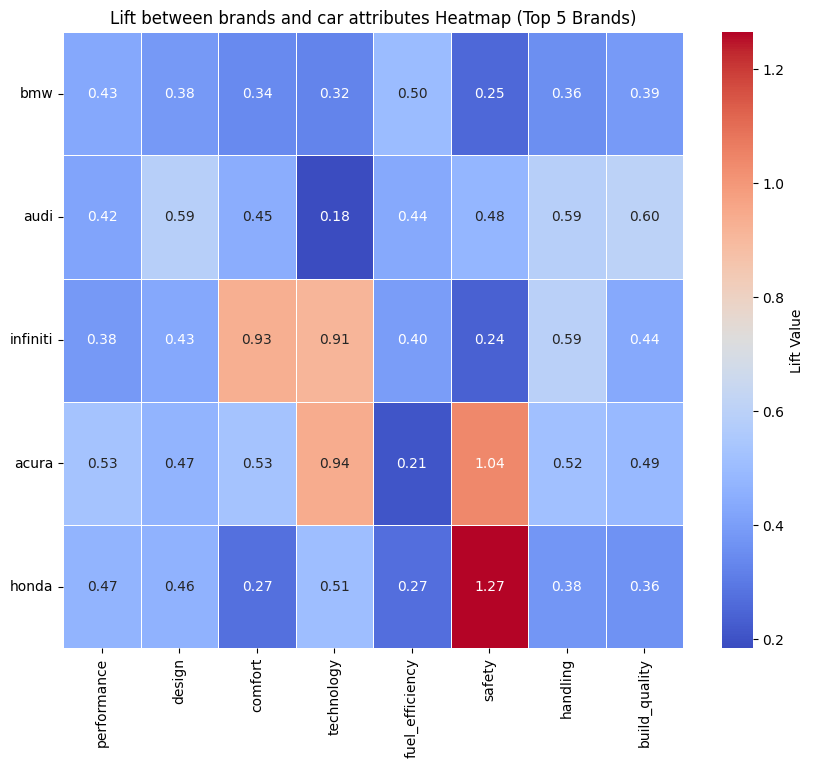

In [82]:
#Calculating lift between brands and car attribututes as a measure of association

# Total number of comments
total_comments = len(top_5_brands_comments_df)

# Calculate the total mentions of each brand
brand_mentions = top_5_brands_comments_df['brands_mentioned'].explode().value_counts()
brand_probabilities = brand_mentions / total_comments  # P(A) for each brand

# Calculate the total mentions of each attribute category
attribute_totals = attribute_matrix.sum(axis=0)  # Sum of each attribute column
attribute_probabilities = attribute_totals / total_comments  # P(B) for each attribute

# Calculate co-occurrences of brands and attributes (already in attribute_matrix)
co_occurrences = attribute_matrix  # P(A ∩ B) = count of co-occurrences / total_comments
co_occurrence_probabilities = co_occurrences / total_comments

# Calculate lift for each brand-attribute pair
lift_matrix = pd.DataFrame(index=co_occurrences.index, columns=co_occurrences.columns)

for brand in co_occurrences.index:
    for attribute in co_occurrences.columns:
        p_a_b = co_occurrence_probabilities.loc[brand, attribute]
        p_a = brand_probabilities.get(brand, 0)
        p_b = attribute_probabilities.get(attribute, 0)
        lift = p_a_b / (p_a * p_b) if p_a > 0 and p_b > 0 else 0
        lift_matrix.loc[brand, attribute] = lift

# Convert lift_matrix to numeric for better readability
lift_matrix = lift_matrix.apply(pd.to_numeric, errors='coerce')
lift_matrix

# Visualize the lift matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(lift_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={'label': 'Lift Value'})
plt.title('Lift between brands and car attributes Heatmap (Top 5 Brands)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [83]:
# Most 5 frequently mentioned car attributes with these top 5 brands

attribute_totals = attribute_matrix.sum(axis=0)
top_5_attributes = attribute_totals.nlargest(5).index

# Step 3: Filter the attribute_matrix to include only the top 5 most common attributes
filtered_attribute_matrix = attribute_matrix[top_5_attributes]
filtered_attribute_matrix


,performance,design,comfort,build_quality,handling
bmw,1970,1558,578,653,474
audi,539,673,214,286,221
infiniti,343,339,307,143,154
acura,373,293,138,127,106
honda,296,260,64,84,69


First I filtered the attribute_matrix to the 5 common attributes mentioned, but actually the lift for some less commen ones like safety was higher. So for the sake of analysis, I will continue to use the full list of 8 attributes.

Also a note that I know a lift lower than 1 is dissociation but I think since not all comments were about the attributes I chose and they cover many different topics low numbers are lift are not surprising so I analyze the results relatively, rather than actual numbers.

**Task 5: What advice will you give to a (i) product manager and (ii) marketing/advertising manager of these brands based on your analysis in Task 4?**

**Advice to the product managers of these brand in terms of room for development and improvement**

**BMW**: While BMW has moderate lift values for performance and build quality, consider introducing innovations or upgrades in these areas to maintain differentiation.

**Audi**: Audi has relatively low association with technology. Focus on upgrading connectivity and driver-assist features to address this gap.

**Infiniti**: Infiniti is the least known for safety. Address this by introducing more advanced safety technologies and informing customers.

**Acura**: Acura has the least score in fule-efficiency among brands. Your team should start investing in hybrid or electric powertrains, optimizing engine performance, and incorporating advanced energy-saving features  to lower gas costs and reduce environmental impact.

**Honda**: Comfort and build quality are slightly lower compared to competitors. Focus on improving design, engine performance and material quality.

**Advices to marketing managers to what to focus on when introducing their product**

**BMW**: Design campaigns around BMW’s balance of performance, design, fuel efficiency and technology.

**Audi**: Among car brands, people has the highest association of design, handing (control) and build_quality with Audi so marketing activities should highlight that.

**Infiniti**: People know the brand for comfort and technology. Focus on Infiniti’s strength in providing a luxurious and tech-rich experience.

**Acura**: Acura is known as a reliable and tech-driven brand. Highlight Acura's safety features in campaigns to appeal to family-oriented buyers.

**Honda**: Promote Honda's safety features as a key differentiator. It already is a top of mind brand for people concerned for safety. 

**Task 6: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own?**

Using the code below, I analyzed the comments for the top 5 brands to identify words indicating an intention to buy. The results aligned perfectly with our previous analysis. 

BMW emerged as the most aspirational brand, with approximately four times as many mentions related to an intent to purchase compared to the second best brand. 

BMW has a strong brand positioning and stands out as a differentiated one. While BMW's high price is a strategic choice, offering flexible financing options, entry-level models, or targeted promotions could help convert more aspirational buyers into actual customers.


In [85]:
#Define a list of keyword that shows a plan to buy the car
aspirational_keywords = ["want", "wish", "buy","dream", "plan", "purchase"]

# Function to filter comments for aspirational mentions
def contains_aspirational_words(comment):
    return any(keyword in comment for keyword in aspirational_keywords)

top_5_brands_comments_df['aspirational'] = top_5_brands_comments_df['lemmatized_words'].apply(
    lambda words: contains_aspirational_words(' '.join(words))
)

# Count aspirational mentions for each brand
aspirational_counts = {}
for _, row in top_5_brands_comments_df.iterrows():
    if row['aspirational']:
        for brand in row['brands_mentioned']:
            aspirational_counts[brand] = aspirational_counts.get(brand, 0) + 1

aspirational_df = pd.DataFrame(list(aspirational_counts.items()), columns=['Brand', 'Aspirational_Mentions'])
aspirational_df.sort_values(by='Aspirational_Mentions', ascending=False, inplace=True)

aspirational_df


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8612\1625390867.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_brands_comments_df['aspirational'] = top_5_brands_comments_df['lemmatized_words'].apply(


,Brand,Aspirational_Mentions
2,bmw,1232
1,audi,310
9,infiniti,231
3,acura,167
8,honda,159
12,nissan,128
5,toyota,84
0,mercedes,81
13,volvo,60
14,volkswagen,56
